In [10]:
%load_ext autoreload
%aimport processing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
%autoreload 1

import pandas as pd
import numpy as np

import datetime
from datetime import timezone
import pytz

from pycoingecko import CoinGeckoAPI

from processing import Processor

In [12]:
cg = CoinGeckoAPI()

In [13]:
# coin_list = cg.get_coins_list()

# ids = [coin_data['id'] for coin_data in coin_list]

# id_to_data = {}
# for coin_data in coin_list:
#     id_to_data[coin_data.pop('id')] = coin_data
# ids = id_to_data.keys()

In [14]:
# COIN_COLS = ['id', 'symbol', 'name']
# df_coin_names = pd.DataFrame(coin_list, columns=['name'])

# coin_market = cg.get_coins_markets(vs_currency=NAT_CURR)
# df_market = pd.DataFrame(coin_market, columns=['id', 'current_price', 'high_24h', 'low_24h'])
# df_market.set_index('id', inplace=True)

In [92]:
###############
## CONSTANTS ##
###############

NAT_TZ = 'America/Los_Angeles'
NAT_TZOBJ = pytz.timezone(NAT_TZ)

TRG_TZOBJ = timezone.utc

PORT_IDS = ['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']

NAT_CURR = 'usd'

ROLL_WIND = 14
LOOKBACKS = [7, 14, 30]

In [93]:
##################
## LOCAL DRIVER ##
##################

start_date, end_date = (2018,9,1), (2020,9,1)

processor = Processor()

# Create portfolio dataframe
port_val = processor.create_portfolio(cg, PORT_IDS, start_date, end_date)
data = processor.data

processor.normalize([], port=True)

In [94]:
display(data)

,bitcoin,bitcoin-cash,ethereum,litecoin
1535760000000,7027.631279,543.434677,282.223179,62.052262
1535846400000,7211.270768,618.518626,295.646162,66.466811
1535932800000,7305.272801,649.278293,294.585688,66.208480
1536019200000,7260.897517,628.023667,288.852826,65.375997
1536105600000,7359.462993,626.230974,285.485757,67.655937
...,...,...,...,...
1598572800000,11300.398364,263.983814,381.837651,55.958029
1598659200000,11519.118388,268.346874,395.138213,57.191844
1598745600000,11481.481823,268.156612,399.374544,57.075600
1598832000000,11701.004009,278.464590,428.295679,62.738516


<Figure size 432x288 with 0 Axes>

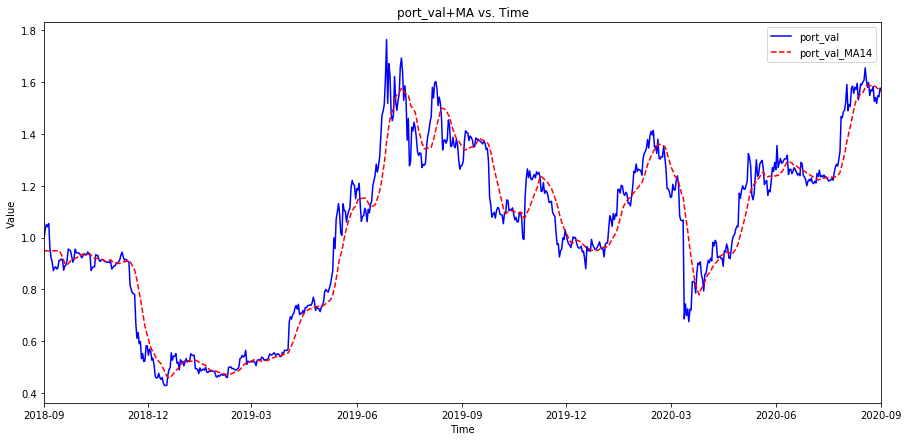

t-stat = -10.36535966557335: The series port_val_RM_I is stationary with confidence level  99%
(-10.365871577841402, 3.0028228171110685e-17, array([-3.91148482, -3.34450132, -3.05025701]))


In [95]:
############
## TEST 1 ##
############

# Create normalized timeseries for portfolio
port_rm = processor.take_roll_avg(ROLL_WIND)
port_rm.name = f'{port_val.name}_RM'


# IF a random variable is stationary THEN it is also order one integratable #

port_ret = processor.integrate(port_rm)

comparator = port_ret + np.random.normal(0, 5, len(port_ret))

# These two series should be stationary and cointegrate
coint_res = processor.is_coint(port_ret, comparator)
print(coint_res)

### Testing cointegration of crypto basket
Test cointegration of coin basket: {coins} = {c_1,...,c_n}
ie. Check that the set {coins} is cointegrated using Engle-Granger two-step test
This means there is some STATIONARY linear combination of {coins}

<ol>
    <li>Check that c_i is non-stationary and order-1 integrable</li>
    <li>Using Multivariate Linear Regression, find coef_ for Linear Combination of {coins}</li>
    <li>Check that the linear regression RESIDUAL is stationary using Augmented Dickey-Fuller test</li>
</ol>

Then, {coins} is cointegrated

#### Concerns
<ul>
    <li>Should we normalize data before running our regression?</li>
</ul>

#### Conclusions
<ul>
    <li>OLS and Linear Regression yield the same coefficients</li>
    <li>While we usually assume stock data is I(1), it sometimes isn't (eg. Litecoin, BTC-Cash)</li>
    <li>As of now, we have not found a regression that makes th residuals stationay (ie. not cointegrated)</li>
    <li>Normalization might help us find a regression line that does cointegrate the portfolio</li>
    <li>We should run this test on different coins in different sized baskets.</li>
</ul>

In [136]:
############
## TEST 2 ##
############

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

print("Verifying coin price stationarity...")
stationarity = []
for coin in data:
    coin_stationarity = processor.test_stationarity(data[coin])
    coin_prime = processor.differentiate(data[coin])
    coin_prime_stationarity = processor.test_stationarity(coin_prime)
    stationarity.append(not coin_stationarity & coin_prime_stationarity)
print(stationarity) # BITCOIN CASH IS NOT ORDER 1 INTEGRABLE

lm = LinearRegression(copy_X=True)
X = data.drop(['bitcoin'], axis=1)
y = data['bitcoin']

print("Normalizing...")
scaler = MinMaxScaler()
scaler.fit(X, y)
X_scaled = scaler.transform(X) # TODO: Finish normalization

lm.fit(X, y)
coef = lm.coef_
constant = lm.intercept_

residuals = y - X.multiply(coef).sum(axis=1) - constant
residuals.name = 'Residuals'

is_stationary = processor.test_stationarity(residuals, pct='5%')

# USING OLS INSTEAD

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
display(est.summary())

coef_ols = est.params.values
residuals = y - X.multiply(coef_ols).sum(axis=1)
is_stationary = processor.test_stationarity(residuals, pct='5%')

Verifying coin price stationarity...
t-stat = -1.0677438120387919 The series bitcoin is not stationary with confidence level  99%
t-stat = -29.393023446775963: The series bitcoin_D is stationary with confidence level  99%
t-stat = -3.5550256014355104: The series bitcoin-cash is stationary with confidence level  99%
t-stat = -12.204901127793267: The series bitcoin-cash_D is stationary with confidence level  99%
t-stat = -0.8155659195808184 The series ethereum is not stationary with confidence level  99%
t-stat = -5.777923492084548: The series ethereum_D is stationary with confidence level  99%
t-stat = -2.0640409620482507 The series litecoin is not stationary with confidence level  99%
t-stat = -5.468682330640807: The series litecoin_D is stationary with confidence level  99%
[True, False, True, True]
Normalizing...
t-stat = -1.439085844586164 The series Residuals is not stationary with confidence level  95%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                bitcoin   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     345.0
Date:                Mon, 01 Nov 2021   Prob (F-statistic):          2.53e-139
Time:                        02:41:08   Log-Likelihood:                -6426.4
No. Observations:                 732   AIC:                         1.286e+04
Df Residuals:                     728   BIC:                         1.288e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1822.8410    199.554      9.135      0.000    1431.070    2214.612
bitcoin-cash    -1.2194      0.691     -1.766      0.078      -2.575       0.136
ethereum        25.8372      1.082     23.888      0.000      23.714      27.961
litecoin        17.6941      3.134      5.645      0.000      11.541      23.848
==============================================================================
Omnibus:                      953.188   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.131
Skew:                           0.087   Prob(JB):                     1.30e-11
Kurtosis:                       1.730   Cond. No.                     1.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

t-stat = -1.439085844586165 The series None is not stationary with confidence level  95%


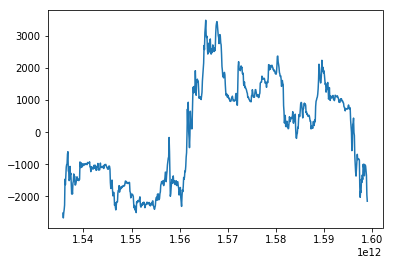

In [137]:
import matplotlib.pyplot as plt
plt.plot(residuals)

In [ ]:
############
## TEST 3 ##
############

col_1, col_2 = port_df.columns[:2]
s_1, s_2 = port_df[col_1], port_df[col_2]

# Random two series likely should not be stationary
coint_res = is_coint(s_1, s_2)
print(coint_res)

In [ ]:
take_mean(port_val)
df_feats = series_to_df_feats(port_val, LOOKBACKS, plot=True)

print(sharpe_ratio(df_feats['port_val_DR']))
